# ELO

In [138]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import pendulum
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
import utils

In [78]:
class Game:
    def __init__(self, dt, game_id, home, away, home_mov, home_elo=None, away_elo=None,point_spread=None,homefield=100,k=22):
        self.game_id = game_id
        self.dt = dt
        self.home = home
        self.away = away
        self.home_mov = home_mov
        self.point_spread = point_spread
        
        self.home_elo = home_elo
        self.away_elo = away_elo
        
        
        self.homefield = homefield
        self.k = k
    
    def _get_q(self, elo):
        q = 10 ** (elo / 400)
        
        return q
    
    def get_home_expectation(self):
        home_elo = self.home_elo + self.homefield
        
        expectation = (
            self._get_q(home_elo) / (self._get_q(self.away_elo) + self._get_q(home_elo))
        )
        
        return expectation
    
    def UpdateElo(self):
        if self.get_home_expectation() >= 0.5 and self.home_mov > 0:
            self.home_elo = self.home_elo + self.k * (1 - self.get_home_expectation())
            self.away_elo = self.away_elo - self.k * (1 - self.get_home_expectation())
        
        elif self.get_home_expectation() >= 0.5 and self.home_mov < 0:
            self.home_elo = self.home_elo - self.k * (self.get_home_expectation())
            self.away_elo = self.away_elo + self.k * (self.get_home_expectation())
        
        elif self.get_home_expectation() < 0.5 and self.home_mov < 0:
            self.home_elo = self.home_elo - self.k * (self.get_home_expectation())
            self.away_elo = self.away_elo + self.k * (self.get_home_expectation())
        
        elif self.get_home_expectation() < 0.5 and self.home_mov > 0:
            self.home_elo = self.home_elo + self.k * (1 - self.get_home_expectation())
            self.away_elo = self.away_elo - self.k * (1 - self.get_home_expectation())
            
def clean_br_date(input_string):
    day_of_week, raw_month, raw_date, raw_year = input_string.split(' ')
    if raw_month == 'Dec':
        month = 12
    elif raw_month == 'Jan':
        month = 1
    elif raw_month == 'Feb':
        month = 2
    elif raw_month == 'Mar':
        month = 3
    elif raw_month == 'Apr':
        month = 4
    elif raw_month == 'May':
        month = 5
        
    year = int(raw_year)
    day = int(raw_date)
    
    return pendulum.Date(year, month, day)

def get_elo(team, elos):
    elo = (
        elos
        .query(f'team == "{team}"')
        .sort_values(by='dt', ascending=False)
        .elo
        .tolist()
        [0]
    )
    
    return elo

In [3]:
df = pd.read_csv('../data/NBA Scores and Point Spreads.csv')

In [106]:
games = (
    df
    .query('game_number <= 82')
    .query('season >= "2008-09"')
    .query('home_away == "Home"')
    [['game_id', 'season', 'dt', 'team', 'opponent', 'mov', 'point_spread', 'game_number']]
    .rename(
        columns={
            'team': 'home',
            'opponent': 'away',
            'mov': 'home_mov'
        }
    )
    .sort_values(
        by=['season', 'dt', 'home']
    )
    .assign(
        dt = lambda x: x['dt'].apply(utils.clean_date)
    )
)

games.tail(10)

,game_id,season,dt,home,away,home_mov,point_spread,game_number
38717,ea48985bdcb918f19a9a443bd9e2cdd3,2022-23,2022-12-10,Miami,SanAntonio,-4,-12.0,27.0
38983,dc6dec95fe5845c04a5ee941b9114ea2,2022-23,2022-12-10,Portland,Minnesota,6,-5.5,26.0
39117,ea252a4d92c55b786f23138cb671412d,2022-23,2022-12-10,Washington,LAClippers,-7,5.0,27.0
38342,bbb7141a0ef6c522272d91108bbca97d,2022-23,2022-12-11,Atlanta,Chicago,1,-3.5,27.0
38530,47b2efcef107631e33fb88415265d618,2022-23,2022-12-11,Detroit,LALakers,-7,5.0,29.0
38583,2821a94f38d661ae7edfa86e8a50325b,2022-23,2022-12-11,Houston,Milwaukee,5,10.0,26.0
38823,879e6ade0daa4d622ed9ccc61477f1c6,2022-23,2022-12-11,NewOrleans,Phoenix,5,-3.5,26.0
38850,1d6f3ae7deea41c203d3e71544206b05,2022-23,2022-12-11,NewYork,Sacramento,13,-2.5,27.0
38904,380ac405ac1f057627885807fe70ecf2,2022-23,2022-12-11,Orlando,Toronto,12,6.5,28.0
38930,0b03297c101c3e8cfd5eaaf0b3f5ef4d,2022-23,2022-12-11,Philadelphia,Charlotte,18,-10.5,26.0


In [74]:
teams = games.home.unique().tolist()

elos = pd.DataFrame(
    {
        'team': teams,
        'elo': np.repeat(1500, len(teams)),
        'dt': np.repeat(pendulum.Date(2007,10,31), len(teams))
    }
)

elos.tail()

,team,elo,dt
25,Indiana,1500,2007-10-31
26,Milwaukee,1500,2007-10-31
27,Nets,1500,2007-10-31
28,NewOrleans,1500,2007-10-31
29,Sacramento,1500,2007-10-31


## Run Simulation

In [79]:
rows = []

for raw in games.to_dict('records'):
    game = Game(home=raw['home'], away=raw['away'], dt=raw['dt'], home_mov=raw['home_mov'], point_spread=raw['point_spread'], game_id=raw['game_id'])
    game.home_elo = get_elo(game.home, elos)
    game.away_elo = get_elo(game.away, elos)
    
    # Pre-game info
    
    row = {
        'game_id': game.game_id,
        'home': game.home,
        'away': game.away,
        'home_elo': game.home_elo,
        'away_elo': game.away_elo,
        'home_mov': game.home_mov,
        'point_spread': game.point_spread,
        'dt': game.dt,
    }
   
    game.UpdateElo()
    home_update = {
        'team': game.home,
        'elo': game.home_elo,
        'dt': game.dt
    }
    
    elos = elos.append(home_update, ignore_index=True)

    away_update = {
        'team': game.away,
        'elo': game.away_elo,
        'dt': game.dt
    }
    
    
    # Write to database: Elos
    elos = elos.append(away_update, ignore_index=True)
    
    # Write to database: Pre and Post Game elos, plus game result and point spread.
    post_game_update = {
        'home_elo__post': game.home_elo,
        'away_elo__post': game.away_elo,
    }

    row.update(post_game_update)
    
    rows.append(row)

## Review

In [81]:
dates = elos.dt.unique().tolist()

final = (
    pd.DataFrame({'dt': dates})
    .merge(
        pd.DataFrame({'team': teams}),
        how='cross'
    )
    .assign(
        dummy='dummy'
    )
    .merge(
        elos,
        on=['dt', 'team'],
        how='left'
    )
    .assign(
        elo = lambda x: x.groupby('team')['elo'].transform(lambda s: s.ffill())
    )
    .merge(
        (
            games
            [['season', 'dt']]
            .drop_duplicates()
        ),
        on='dt',
        how='left'
    )
)

final.tail()

,dt,team,dummy,elo,season
69656,2022-12-11,Indiana,dummy,1400.554309,2022-23
69657,2022-12-11,Milwaukee,dummy,1616.599335,2022-23
69658,2022-12-11,Nets,dummy,1540.891105,2022-23
69659,2022-12-11,NewOrleans,dummy,1571.910080,2022-23
69660,2022-12-11,Sacramento,dummy,1485.611581,2022-23


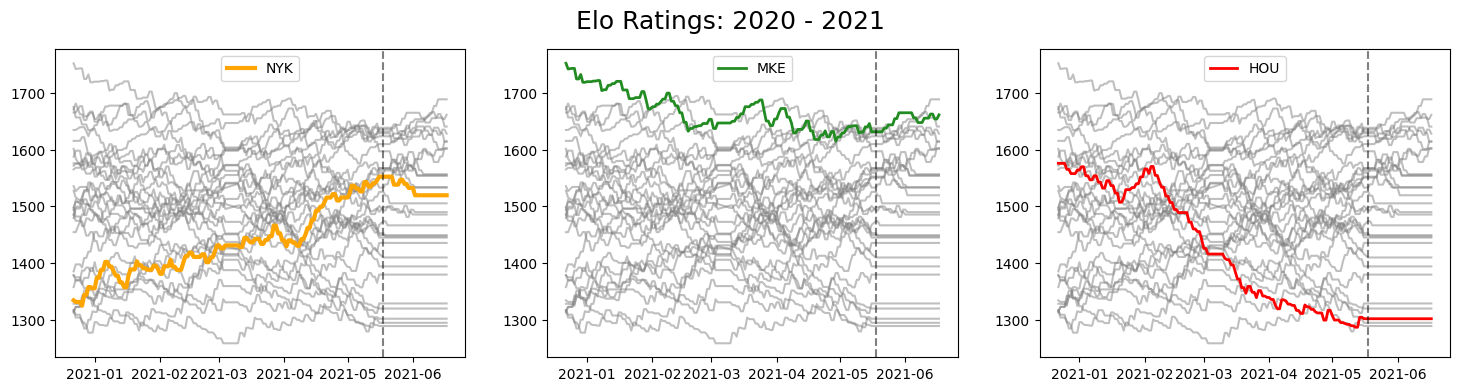

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))

team = 'NewYork'

(
    final
    .query(f'team != "{team}"')
    .query('season == "2020-21"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax1
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='Orange',
        ax=ax1,
        label='NYK',
        lw=3
    )
)

team = 'Milwaukee'

(
    final
    .query('season == "2020-21"')
    .query(f'team != "{team}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax2
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='forestgreen',
        ax=ax2,
        label='MKE',
        lw=2
    )
)

ax1.set_xlabel('')
ax2.set_xlabel('')

team = 'Houston'

(
    final
    .query('season == "2020-21"')
    .query(f'team != "{team}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax3
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='red',
        ax=ax3,
        label='HOU',
        lw=2
    )
)

ax1.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax2.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax3.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

plt.suptitle('Elo Ratings: 2020 - 2021', size=18)
plt.show()

## Is it Good?

Vegas and Elo batting averages, by season.

In [107]:
home_field_advantage = 100

scoreboard = (
    pd.DataFrame(rows)
    .assign(
        elo_diff = lambda x: x['home_elo'] - x['away_elo'] + home_field_advantage,
        winner = lambda x: x['home_mov'].transform(lambda s: 'Away' if s < 0 else 'Home'),
        
        vegas_prediction = lambda x: x['point_spread'].transform(lambda s: 'Home' if s < 0 else 'Away'),
        elo_prediction = lambda x: x['elo_diff'].transform(lambda s: 'Away' if s < 0 else 'Home'),
        
        vegas_correct = lambda x: x['winner'] == x['vegas_prediction'],
        elo_correct = lambda x: x['winner'] == x['elo_prediction']
        
    )
    .merge(
        (
            games
            [['season', 'game_id', 'game_number']]
            .drop_duplicates()
        ),
        on='game_id',
        how='left'
    )
)

scoreboard.tail(20)

,game_id,home,away,home_elo,away_elo,home_mov,point_spread,dt,home_elo__post,away_elo__post,elo_diff,winner,vegas_prediction,elo_prediction,vegas_correct,elo_correct,season,game_number
17065,d4d081054ab119583e3dc4862a102ef3,Nets,Atlanta,1523.235532,1512.643876,4,-7.0,2022-12-09,1530.847790,1505.248270,110.591656,Home,Home,Home,True,True,2022-23,27.0
17066,ac266b6ab35a4dbe33ea0bb5f27a43b3,NewOrleans,Phoenix,1551.262755,1640.340162,11,1.5,2022-12-09,1561.917054,1630.022421,10.922593,Home,Away,Home,False,True,2022-23,25.0
17067,c1a0626042b6e6fd7b8bc8d38f192afc,Orlando,Toronto,1294.527506,1538.146225,4,8.5,2022-12-09,1309.832120,1523.258883,-143.618719,Home,Away,Away,False,False,2022-23,27.0
17068,daec343d40932439249d1183ac4eba94,Philadelphia,LALakers,1551.111037,1425.967925,11,-5.0,2022-12-09,1555.837391,1421.341752,225.143112,Home,Home,Home,True,True,2022-23,25.0
17069,e6730803068407a5154632c40c31c856,Utah,Minnesota,1535.383516,1508.702720,-10,0.0,2022-12-09,1520.541502,1523.126162,126.680795,Away,Away,Home,True,False,2022-23,28.0
17070,5054b09e0b0fd3f82134bbbdcd14ae05,Chicago,Dallas,1474.493503,1576.205481,29,-5.0,2022-12-10,1485.547705,1565.501190,-1.711978,Home,Home,Away,True,False,2022-23,25.0
17071,3483d8c7f45d20aa4f8ef2b1136595ec,Cleveland,OklahomaCity,1502.376453,1393.407592,8,-4.5,2022-12-10,1507.457483,1388.439952,208.968861,Home,Home,Home,True,True,2022-23,27.0
17072,568cdce3b618ce074b46e10b0aa224c7,Denver,Utah,1560.727831,1520.541502,5,-11.5,2022-12-10,1567.515600,1513.935740,140.186329,Home,Home,Home,True,True,2022-23,26.0
17073,261b37a776c6022e07d21dea6540622e,GoldenState,Boston,1524.290490,1693.152780,16,2.5,2022-12-10,1537.442600,1680.403928,-68.862290,Home,Away,Away,False,False,2022-23,27.0
17074,4541d8a27f86846e408fc7238f8e6374,Indiana,Nets,1410.924208,1530.847790,-3,-8.5,2022-12-10,1400.554309,1540.891105,-19.923582,Away,Home,Away,False,True,2022-23,27.0


In [108]:
vegas_confusion = (
    scoreboard
    .groupby(['winner', 'vegas_prediction'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .pivot_table(
        index='vegas_prediction',
        columns='winner',
        values='games'
    )
)

display(Markdown('### Vegas Confusion Matrix'))
display(vegas_confusion)

elo_confusion = (
    scoreboard
    .groupby(['winner', 'elo_prediction'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .pivot_table(
        index='elo_prediction',
        columns='winner',
        values='games'
    )
)

display(Markdown('### Elo Confusion Matrix'))
display(elo_confusion)

### Vegas Confusion Matrix

winner,Away,Home
vegas_prediction,,
Away,3841,2091
Home,3269,7884


### Elo Confusion Matrix

winner,Away,Home
elo_prediction,,
Away,3083,1811
Home,4027,8164


In [131]:
batting_average__vegas = (
    scoreboard
    .groupby(['season', 'game_number', 'vegas_correct'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .assign(
        cumulative_mean = lambda x: x.groupby(['season', 'vegas_correct'])['games'].transform(lambda s: s.expanding().mean())
    )
    .pivot_table(
        index=['season', 'game_number'],
        columns='vegas_correct',
        values='cumulative_mean'
    )
    .reset_index()
    .set_axis(['season', 'game_number', 'incorrect', 'correct'], axis=1)
    .assign(
        total = lambda x: x['incorrect'] + x['correct'],
        ## Calculate Vegas batting average:
        Vegas = lambda x: 100 * x['correct'] / x['total']

    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['season', 'game_number', 'Vegas']]
)

batting_average__elo = (
    scoreboard
    .groupby(['season', 'game_number', 'elo_correct'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .assign(
        cumulative_mean = lambda x: x.groupby(['season', 'elo_correct'])['games'].transform(lambda s: s.expanding().mean())
    )
    .pivot_table(
        index=['season', 'game_number'],
        columns='elo_correct',
        values='cumulative_mean'
    )
    .reset_index()
    .set_axis(['season', 'game_number', 'incorrect', 'correct'], axis=1)
    .assign(
        total = lambda x: x['incorrect'] + x['correct'],
        ## Calculate Elo batting average:
        Elo = lambda x: 100 * x['correct'] / x['total']

    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['season', 'game_number', 'Elo']]
)

batting_averages = (
    batting_average__elo
    .merge(
        batting_average__vegas
    )
    .melt(
        id_vars=['season', 'game_number'],
        var_name='Predictor',
        value_name='Batting Average'
    )
)

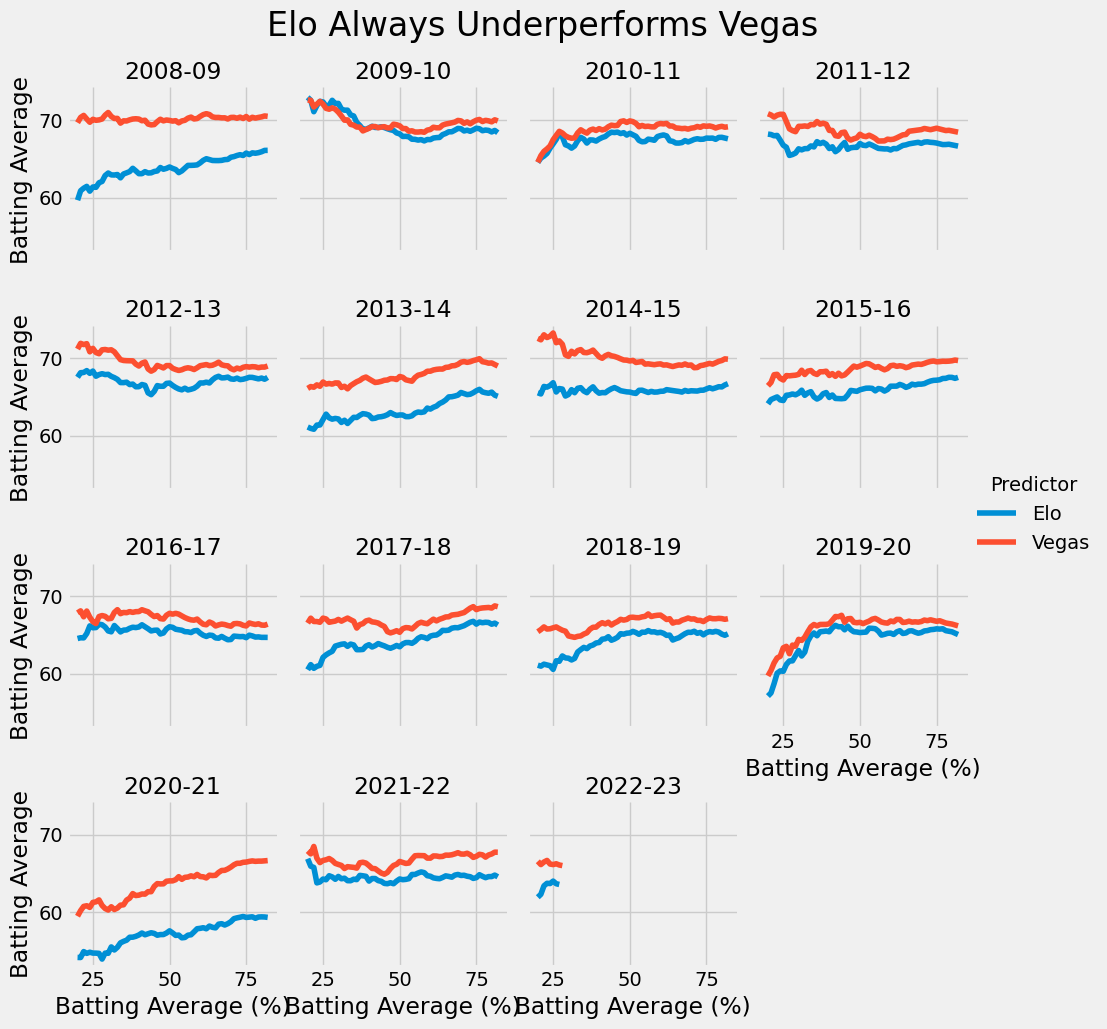

In [157]:
style.use('fivethirtyeight')

g = sns.relplot(
    data=batting_averages,
    x='game_number',
    y='Batting Average',
    hue='Predictor',
    col='season',
    col_wrap=4,
    kind='line',
    height=2.5,
    aspect=1
)

g.set_axis_labels("Batting Average (%)")
g.set_titles(col_template="{col_name}")

g.fig.suptitle('Elo Always Underperforms Vegas', y=1.03, size=24)

plt.show()

In [151]:
(
    batting_averages
    .query('game_number == 82')
    .pivot_table(
        index='season', 
        columns='Predictor', 
        values='Batting Average'
    )
    .round(1)
)

Predictor,Elo,Vegas
season,,
2008-09,66.1,70.5
2009-10,68.4,69.9
2010-11,67.6,69.1
2011-12,66.6,68.4
2012-13,67.5,69.0
2013-14,65.1,69.0
2014-15,66.7,69.9
2015-16,67.5,69.7
2016-17,64.7,66.4
